In [50]:
import sigfig
import polars as pl
from refnx.analysis import Transform, GlobalObjective

import pyref.fitting as fit
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

from typing import Any
from matplotlib.figure import Figure

# Load the Data Files


Dataset loaded from reflectivity_data.parquet


(<Axes: ylabel='$R$'>, <Axes: xlabel='$q (\\AA^{-1})$'>)

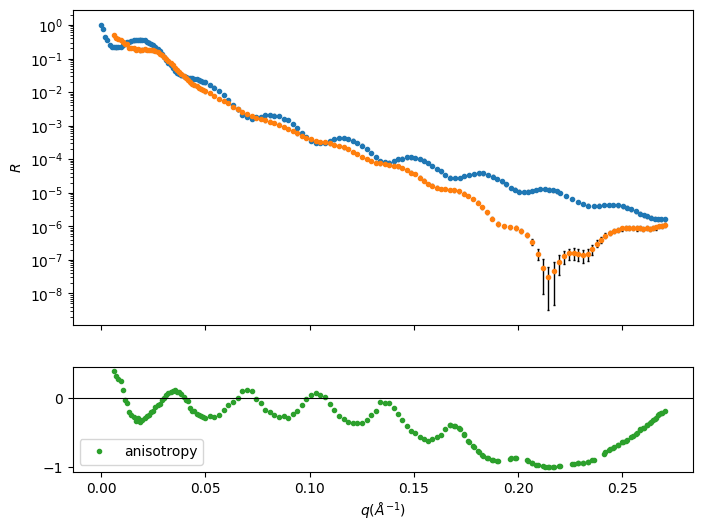

In [51]:
def save_reflectivity_dataset(data_dict, filename):
    """
    Save reflectivity dataset to a parquet file.

    Parameters
    ----------
    data_dict : dict
        Dictionary containing XrayReflectDataset objects with energy keys
    filename : str
        Output filename (should end with .parquet)
    """
    # Convert datasets to DataFrame format
    rows = []

    for energy_str, dataset in data_dict.items():
        energy = float(energy_str)

        # Extract Q, R, and dR arrays
        Q = dataset.data[0]  # x-axis (Q values)
        R = dataset.data[1]  # y-axis (reflectivity)
        dR = dataset.data[2]  # errors

        # Create rows for this energy
        for q, r, dr in zip(Q, R, dR):
            rows.append({"energy": energy, "Q": q, "R": r, "dR": dr})

    # Convert to polars DataFrame and save
    df_save = pl.DataFrame(rows)
    df_save.write_parquet(filename)
    print(f"Dataset saved to {filename}")


def load_reflectivity_dataset(filename):
    """
    Load reflectivity dataset from a parquet file.

    Parameters
    ----------
    filename : str
        Input filename (should be a .parquet file)

    Returns
    -------
    dict
        Dictionary containing XrayReflectDataset objects with energy keys
    """
    # Load the DataFrame
    df_load = pl.read_parquet(filename)

    # Reconstruct the data dictionary
    data_reconstructed = {}

    # Group by energy
    for group_key, group_data in df_load.group_by("energy"):
        energy_val = group_key[0]  # Extract energy value from the group key tuple

        # Extract arrays
        Q = group_data["Q"].to_numpy()
        R = group_data["R"].to_numpy()
        dR = group_data["dR"].to_numpy()

        # Create XrayReflectDataset
        dataset = fit.XrayReflectDataset(data=(Q, R, dR))
        data_reconstructed[str(energy_val)] = dataset

    print(f"Dataset loaded from {filename}")
    return data_reconstructed


# # Save the dataset to a parquet file
# save_reflectivity_dataset(data, "reflectivity_data.parquet")
# # Load the dataset back from the parquet file
loaded_data = load_reflectivity_dataset("reflectivity_data.parquet")
loaded_data["283.7"].plot(label="283.7 eV data")

# Load Optical Constants for Constraints and OOC instantiation


In [52]:
import pickle

ooc = pd.read_csv("optical_constants.csv")
energy = [float(e) for e in loaded_data.keys()]
with open("fitting_results_fixed.pkl", "rb") as f:
    fitting_results = pickle.load(f)


def get_objective_at_energy(global_objective, energy):
    """
    Retrieve the GlobalObjective object for a specific energy from fitting results.

    Parameters
    ----------
    fitting_results : dict
        Dictionary containing fitting results with energy keys.
    energy : float
        The energy value for which to retrieve the GlobalObjective.

    Returns
    -------
    GlobalObjective
        The GlobalObjective object corresponding to the specified energy.
    """
    for o in global_objective.objectives:
        if np.isclose(o.model.energy, energy):
            return o
    raise ValueError(f"No objective found for energy {energy}")


def get_optical_constants(objective):
    """
    Extract optical constants from a GlobalObjective object for a specific energy.

    Parameters
    ----------
    global_objective : GlobalObjective
        The GlobalObjective object containing the fitting results.
    energy : float
        The energy value for which to extract the optical constants.

    Returns
    -------
    tuple
        A tuple containing (delta, beta) for the specified energy.
    """
    sld_spec = {
        "density": [],
        "rotation": [],
        "energy_offset": [],
        "tensor": [],
        "thickness": [],
        "roughness": [],
    }
    structure = objective.model.structure
    for layer in structure:
        sld = layer.sld
        sld_spec["density"].append(sld.density.value)
        sld_spec["rotation"].append(sld.rotation.value)
        sld_spec["energy_offset"].append(sld.energy_offset.value)
        tensor = sld.tensor
        sld_spec["tensor"].append(tensor)
        sld_spec["thickness"].append(layer.thick.value)
        sld_spec["roughness"].append(layer.rough.value)
    return sld_spec


slds = {}
for o in fitting_results.objectives:
    e = o.model.energy
    sld_spec = get_optical_constants(o)
    slds[str(e)] = sld_spec
slds

{'250.0': {'density': [np.float64(0.0),
   np.float64(1.4655185072454873),
   np.float64(1.6536033989187757),
   np.float64(1.8),
   np.float64(2.145078869107535),
   np.float64(2.4432714412232603)],
  'rotation': [np.float64(0.0),
   np.float64(0.8015911159304013),
   np.float64(1.2069625690959114),
   np.float64(0.9036337915490659),
   np.float64(0.0),
   np.float64(0.0)],
  'energy_offset': [np.float64(-0.0017356089472281649),
   np.float64(-0.0017356089472281649),
   np.float64(-0.0017356089472281649),
   np.float64(-0.0017356089472281649),
   np.float64(-0.0017356089472281649),
   np.float64(-0.0017356089472281649)],
  'tensor': [array([[0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j]]),
   array([[0.00275385+0.00035459j, 0.        +0.j        ,
           0.        +0.j        ],
          [0.        +0.j        , 0.00275385+0.00035459j,
           0.        +0.j        ],
          [0.        +0.j        , 0.        +0.j        ,
 

In [53]:
with open("slds_dict.pkl", "wb") as f:
    pickle.dump(slds, f)
print("slds dictionary saved to slds_dict.pkl")

slds dictionary saved to slds_dict.pkl


In [54]:
with open("slds_dict.pkl", "rb") as f:
    slds = pickle.load(f)

In [55]:
ZNPC = "C32H16N8Zn"
MA = np.asin(np.sqrt(2 / 3))


def setp_from_tensor(slab):
    """Set parameters from tensor."""
    tensor = slab.sld.tensor
    uniaxial_measure = tensor[2, 2] - tensor[0, 0]
    isotropic = tensor.trace() / 3
    diso = isotropic.real
    biso = isotropic.imag
    dichroism = uniaxial_measure.imag
    birefringence = uniaxial_measure.real

    # Handle birefringence/delta parameters
    if np.isclose(birefringence, 0):
        slab.sld.delta.setp(vary=True, bounds=(diso * 0.5, diso * 2))
        slab.sld.birefringence.setp(value=0, vary=False)
    else:
        birefringent_bounds = (
            (0, 5 * birefringence) if birefringence > 0 else (5 * birefringence, 0)
        )
        isotropic_bounds = (
            diso - 5 * abs(birefringence),
            diso + 5 * abs(birefringence),
        )
        slab.sld.birefringence.setp(vary=True, bounds=birefringent_bounds)
        slab.sld.delta.setp(vary=True, bounds=isotropic_bounds)

    # Set constraints for xx and zz components
    slab.sld.xx.setp(vary=None, constraint=slab.sld.delta - slab.sld.birefringence)
    slab.sld.zz.setp(vary=None, constraint=slab.sld.delta + slab.sld.birefringence)

    # Handle dichroism/beta parameters
    if np.isclose(dichroism, 0):
        slab.sld.beta.setp(vary=True, bounds=(biso * 0.5, biso * 2))
        slab.sld.dichroism.setp(value=0, vary=False)
    else:
        dichroic_bounds = (0, 5 * dichroism) if dichroism > 0 else (5 * dichroism, 0)
        isotropic_bounds = (
            max(biso - 5 * abs(dichroism), 0),
            biso + 5 * abs(dichroism),
        )
        slab.sld.dichroism.setp(vary=True, bounds=dichroic_bounds)
        slab.sld.beta.setp(vary=True, bounds=isotropic_bounds)

    # Set constraints for ixx and izz components
    slab.sld.ixx.setp(vary=None, constraint=slab.sld.beta - slab.sld.dichroism)
    slab.sld.izz.setp(vary=None, constraint=slab.sld.beta + slab.sld.dichroism)

    return slab


def vacuum(energy):
    """Vacuum."""
    slab = fit.MaterialSLD("", 0, name=f"Vacuum_{energy}")(0, 0)
    slab.thick.setp(vary=False)
    slab.rough.setp(vary=False)
    slab.sld.density.setp(vary=False)
    return slab


def substrate(energy, thick=0, rough=1.2, density=2.44):
    """Substrate."""
    slab = fit.MaterialSLD(
        "Si", density=density, energy=energy, name=f"Substrate_{energy}"
    )(thick, rough)
    slab.thick.setp(vary=False)
    slab.rough.setp(vary=False)
    slab.sld.density.setp(vary=True, bounds=(2.2, 3))
    return slab


def sio2(energy, thick=8.22, rough=6.153, density=2.15):
    """SiO2."""
    slab = fit.MaterialSLD(
        "SiO2", density=density, energy=energy, name=f"Oxide_{round(energy, 1)}"
    )(thick, rough)
    slab.thick.setp(vary=True, bounds=(8, 12))
    slab.rough.setp(vary=True, bounds=(0, 8))
    slab.sld.density.setp(vary=True, bounds=(2, 2.3))
    return slab


def contamination(energy, thick=4.4, rough=2, density=1.0):
    """Contamination."""
    name = f"Contamination_{energy}"
    slab = fit.UniTensorSLD(
        ooc, density=density, rotation=0.81, energy=energy, name=name
    )(thick, rough)
    slab.sld.density.setp(vary=True, bounds=(1, 1.8))
    slab.sld.rotation.setp(vary=True, bounds=(np.pi / 4, 7 * np.pi / 8))

    slab.thick.setp(vary=True, bounds=(0, 12))
    slab.rough.setp(vary=True, bounds=(0, 5))
    return slab


def surface(energy, thick=3.3, rough=1, density=1.0):
    """Surface."""
    name = f"Surface_{energy}"
    slab = fit.UniTensorSLD(
        ooc, density=density, rotation=0.8, energy=energy, name=name
    )(thick, rough)
    slab.sld.density.setp(vary=True, bounds=(1, 1.8))
    slab.sld.rotation.setp(vary=True, bounds=(0, np.pi / 4))

    slab.thick.setp(vary=True, bounds=(0, 12))
    slab.rough.setp(vary=True, bounds=(0, 5))
    return slab


def znpc(energy, thick=191, rough=8.8, density=1.61):
    """ZnPc."""
    name = f"ZnPc_{energy}"
    slab = fit.UniTensorSLD(
        ooc, density=density, rotation=1.35, energy=energy, name=name
    )(thick, rough)
    slab.sld.density.setp(vary=True, bounds=(1.2, 1.8))
    slab.sld.rotation.setp(vary=True, bounds=(MA, np.pi / 2))

    slab.thick.setp(vary=True, bounds=(180, 210))
    slab.rough.setp(vary=True, bounds=(2, 16))
    return slab


def construct_slab(
    energy,
    offset=0,
):
    """Construct the slab."""
    offset_energy = energy  # round(energy + offset, 1)
    slab = (
        vacuum(offset_energy)
        | surface(offset_energy)
        | znpc(offset_energy)
        | contamination(offset_energy)
        | sio2(offset_energy)
        | substrate(offset_energy)
    )
    slab.name = f"Monolayer_{energy + offset}"
    return slab


def construct_slab_from_old(
    energy,
):
    sld_spec = slds[str(energy)]
    offset_energy = energy  # + sld_spec["energy_offset"][0]
    surf = fit.SLD(sld_spec["tensor"][1], name=f"Surface_{energy}")(
        sld_spec["thickness"][1], sld_spec["roughness"][1]
    )
    if energy == 250.0:
        bulk = znpc(
            energy,
            thick=sld_spec["thickness"][2],
            rough=sld_spec["roughness"][2],
            density=sld_spec["density"][2],
        )
    else:
        bulk = fit.SLD(sld_spec["tensor"][2], name=f"Bulk_{energy}")(
            sld_spec["thickness"][2], sld_spec["roughness"][2]
        )
        setp_from_tensor(bulk)
    contam = fit.SLD(sld_spec["tensor"][3], name=f"Contamination_{energy}")(
        sld_spec["thickness"][3], sld_spec["roughness"][3]
    )
    setp_from_tensor(surf)
    setp_from_tensor(contam)
    slab = (
        vacuum(offset_energy)
        | surf
        | bulk
        | contam
        | sio2(
            offset_energy,
            thick=sld_spec["thickness"][4],
            rough=sld_spec["roughness"][4],
            density=sld_spec["density"][4],
        )
        | substrate(offset_energy, density=sld_spec["density"][5])
    )
    slab.name = f"Monolayer_{energy}"
    return slab


stacks = {str(round(e, 1)): construct_slab_from_old(e) for e in energy}
stacks.keys()

dict_keys(['282.9', '281.6', '283.5', '289.0', '281.4', '282.0', '282.3', '275.0', '284.2', '282.7', '285.1', '281.2', '283.3', '287.0', '281.8', '280.0', '283.7', '282.5', '250.0', '283.1', '281.0'])

In [56]:
def safely_setp(slab, param, **kwargs):
    """Safely set parameters."""
    #  Check if the vary = True while the constraint is not None
    if kwargs.get("vary", False) and kwargs.get("constraint") is not None:
        kwargs["vary"] = None
    if hasattr(slab, param):
        getattr(slab, param).setp(**kwargs)

In [57]:
models = {
    str(e): fit.ReflectModel(
        stacks[str(round(e, 1))], pol="sp", name="Model " + str(e), energy=e
    )
    for e in energy
}

for name, model in models.items():
    if float(name) not in [250, 283.7]:
        model.bkg = 0
    # Constrain the energy offset to be the same for all models
    model.scale_p.setp(vary=True, bounds=(0.8, 1.2))
    model.scale_s.setp(vary=True, bounds=(0.8, 1.2))
    model.theta_offset_p.setp(vary=True, bounds=(-0.1, 0.1))
    model.theta_offset_s.setp(vary=True, bounds=(-0.1, 0.1))
    if model.name.endswith("283.7"):
        model.energy_offset.setp(
            vary=False,
            value=model.structure[0].sld.energy_offset.value,
            bounds=(-0.3, 0.3),
        )
    else:
        model.energy_offset.setp(vary=None, constraint=models["283.7"].energy_offset)

#  Targeted energies for global structure fitting


Now let's fit the global structure parameters using the 283.7 eV dataset for the
tempalte. Then we will fix the thickness and roughness parameters and fit just optical
constants for the remaining systems.


In [ ]:
from typing import TypeVar
import copy
from os import cpu_count
import dynesty
from dynesty import plotting as dyplot
from refnx.analysis import process_chain

T = TypeVar("T")
CPU = cpu_count() // 2 if cpu_count() > 2 else 1


def fit_dynamic(obj: T, CPU=CPU) -> T:
    """Fit the model using dynamic nested sampling."""
    objective: fit.Objective | fit.AnisotropyObjective | fit.GlobalObjective = (
        copy.deepcopy(obj)  # type: ignore[assignment]
    )
    ndim = len(objective.varying_parameters())
    with dynesty.pool.Pool(CPU, objective.logl, objective.prior_transform) as pool:
        nested_sampler = dynesty.DynamicNestedSampler(
            pool.loglike,
            pool.prior_transform,
            ndim=ndim,
            nlive=2 * (ndim + 1),
            pool=pool,
        )
        nested_sampler.run_nested()
    logZdynesty = nested_sampler.results.logz[-1]  # value of logZ
    weights = np.exp(nested_sampler.results.logwt - logZdynesty)
    chain = dynesty.utils.resample_equal(nested_sampler.results.samples, weights)
    process_chain(objective, chain[:, None, :])
    lnz_truth = ndim * -np.log(2 * 10)
    fig, ax = dyplot.runplot(nested_sampler.results, lnz_truth=lnz_truth)
    return objective, nested_sampler  # type: ignore[return-value]


def redch2(obj):
    """Calculate reduced chi2."""
    ndim = len(obj.varying_parameters())
    npoints = obj.npoints
    chi2 = obj.chisqr()
    red_chi2 = chi2 / (npoints - ndim)
    return red_chi2


def rmsd(obj):
    """Calculate RMSD."""
    npoints = obj.npoints
    chi2 = obj.chisqr()
    return np.sqrt(chi2 / npoints)


def AIC(obj):
    """Calculate AIC."""
    ndim = len(obj.varying_parameters())
    ll = obj.logl()
    return 2 * ndim - 2 * ll


#  Constrain the thickness and roughness of each layers to match between energies

ani_weights = np.arange(0, 1.1, 0.1)
chisrs = []
fit_results = []


# Callback function to track parameter values during optimization
def track_parameters(xk, convergence=None):
    """
    Callback function for scipy optimizers to track parameter values.

    Parameters
    ----------
    xk : array_like
        Current parameter vector
    convergence : float, optional
        Current convergence value (not used but required by some optimizers)
    """
    parameter_history.append(xk.copy())
    return False  # Return False to continue optimization


# Initialize list to store parameter history
parameter_history = []

for a in ani_weights:
    a = sigfig.round(a, sigfigs=1)
    print(a)
    models_copy = copy.deepcopy(models)
    struct_obj = fit.AnisotropyObjective(
        models["283.7"], loaded_data["283.7"], logp_anisotropy_weight=float(a)
    )
    fitter = fit.CurveFitter(
        struct_obj,
    )

    fitter.fit(
        target="nlpost",
        method="differential_evolution",
        init="latinhypercube",
        polish=True,
        workers=CPU,
        updating="deferred",
        callback=track_parameters,
    )

    fit_results.append(copy.deepcopy(struct_obj))
    chisrs.append(redch2(struct_obj))
    print(f"Completed fit for anisotropy weight {a}")

0.0


-61.965749758875575: : 114it [01:11,  1.60it/s]


Completed fit for anisotropy weight 0.0
0.1


-61.22085012595493: : 145it [02:38,  1.10s/it] 


Completed fit for anisotropy weight 0.1
0.2


-60.02811215866168: : 104it [02:59,  1.73s/it] 


Completed fit for anisotropy weight 0.2
0.3


-59.35893738055981: : 101it [01:31,  1.10it/s]


Completed fit for anisotropy weight 0.3
0.4


-58.59594243822419: : 141it [02:18,  1.02it/s]


Completed fit for anisotropy weight 0.4
0.5


-57.802022962956784: : 100it [01:43,  1.03s/it]


Completed fit for anisotropy weight 0.5
0.6


-56.935162575623295: : 87it [03:08,  2.17s/it]


Completed fit for anisotropy weight 0.6
0.7


-56.033545023608184: : 81it [00:45,  1.79it/s]


Completed fit for anisotropy weight 0.7
0.8


-54.37644548214543: : 49it [00:34,  1.41it/s] 


Completed fit for anisotropy weight 0.8
0.9


-53.96284846065699: : 26it [01:05,  2.52s/it]

Completed fit for anisotropy weight 0.9


In [72]:
iters = [114, 145, 104, 101, 141, 100, 87, 81, 49, 26, 1]
#  Break parameter history into chunks based on iters
parameter_chunks = []
start = 0
for it in iters:
    end = start + it
    parameter_chunks.append(parameter_history[start:end])
    start = end
len(parameter_chunks[0])

114

(<Axes: ylabel='Reflectivity'>,
 <Axes: xlabel='$q (\\AA^{-1})$', ylabel='Anisotropy'>)

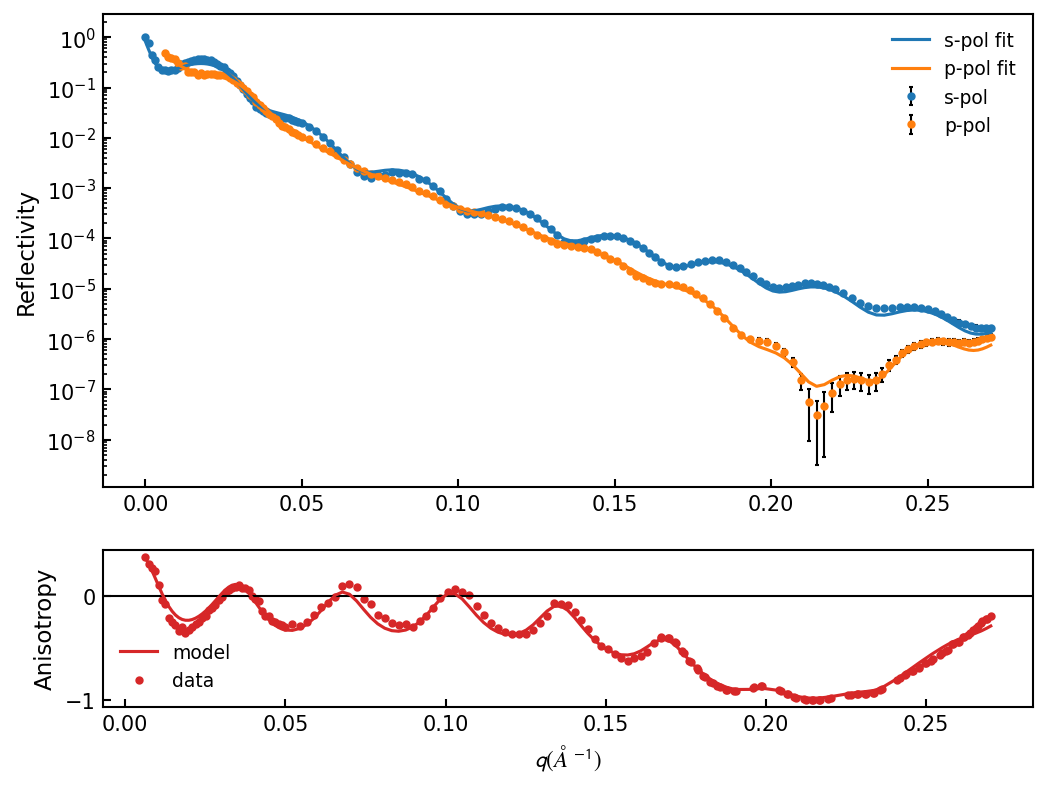

In [152]:
fit_results[-2].plot()

In [ ]:
#  drop the last parameter chunk since it has only one entry
# parameter_chunks = parameter_chunks[:-1]

In [ ]:
# Create a color map for the different anisotropy weights
colors = plt.cm.viridis(np.linspace(0, 1, len(parameter_chunks)))

#  add a new entry for the final fit with weight 1.0
# ani_weights = ani_weights[:-1]

chis = []
for i, param_chunk_series in enumerate(parameter_chunks):
    _chis = []
    for params in param_chunk_series:
        o = fit.AnisotropyObjective(models["283.7"], loaded_data["283.7"])
        o.setp(params)
        _chis.append(redch2(o))
    chis.append(_chis)

In [145]:
import numpy as np
import matplotlib.pyplot as plt


def analyze_convergence(chis, ani_weights):
    """
    Analyze convergence characteristics for different hyperparameters.

    Parameters
    ----------
    chis : list of arrays
        Chi-square values for each iteration for each weight
    ani_weights : array
        Anisotropy weights used

    Returns
    -------
    dict
        Dictionary containing convergence metrics
    """
    convergence_metrics = {}

    for i, chi_history in enumerate(chis):
        weight = ani_weights[i]
        chi_array = np.array(chi_history)

        # Basic metrics
        final_chi = chi_array[-1]
        initial_chi = chi_array[0]
        n_iterations = len(chi_array)

        # Convergence rate (exponential decay fitting)
        iterations = np.arange(len(chi_array))
        if len(chi_array) > 10:  # Need enough points for fitting
            # Fit exponential decay: chi = A * exp(-k * iter) + C
            try:
                from scipy.optimize import curve_fit

                def exp_decay(x, A, k, C):
                    return A * np.exp(-k * x) + C

                popt, _ = curve_fit(
                    exp_decay,
                    iterations,
                    chi_array,
                    bounds=([0, 0, 0], [np.inf, 1, final_chi * 2]),
                )
                convergence_rate = popt[1]  # k parameter
            except:
                convergence_rate = np.nan
        else:
            convergence_rate = np.nan

        # Stability metrics
        last_10_percent = len(chi_array) // 5
        final_values = chi_array[-last_10_percent:]
        stability = np.std(final_values) / np.mean(
            final_values
        )  # Coefficient of variation

        # Improvement per iteration
        improvements = np.diff(chi_array)
        avg_improvement = np.mean(
            improvements[improvements < 12]
        )  # Only negative changes

        # Time to reach 95% of final improvement
        total_improvement = initial_chi - final_chi
        target_chi = initial_chi - 0.95 * total_improvement
        convergence_95_iter = (
            np.argmax(chi_array <= target_chi)
            if np.any(chi_array <= target_chi)
            else n_iterations
        )

        convergence_metrics[weight] = {
            "final_chi": final_chi,
            "initial_chi": initial_chi,
            "n_iterations": n_iterations,
            "convergence_rate": convergence_rate,
            "stability": stability,
            "avg_improvement": avg_improvement,
            "convergence_95_iter": convergence_95_iter,
            "efficiency": total_improvement / n_iterations,  # Improvement per iteration
            "combined_metric": (final_chi + stability * 100 + convergence_95_iter) / 3,
        }

    return convergence_metrics

In [146]:
ani_weights = np.arange(0, 1.0, 0.1)

/tmp/ipykernel_729306/2429562806.py:324: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


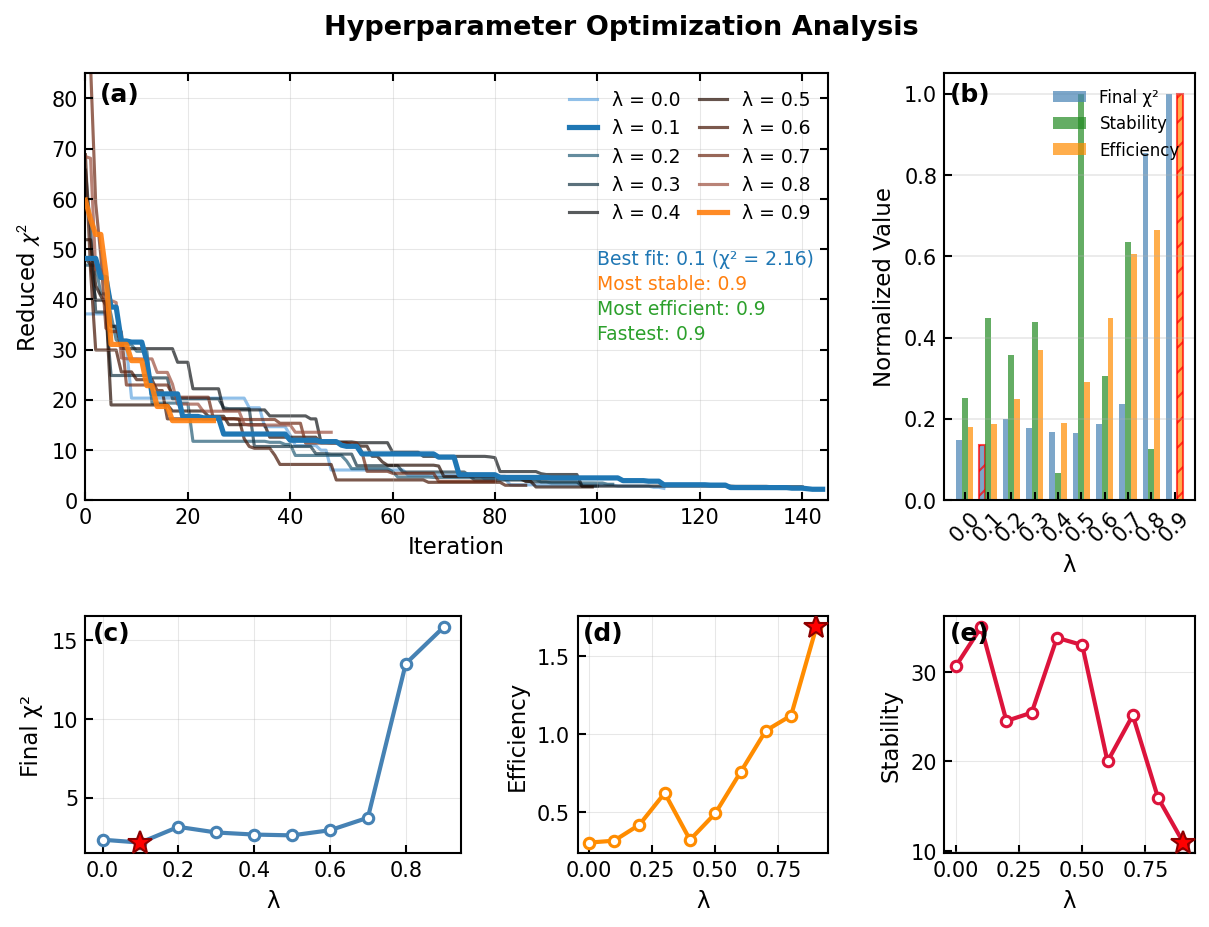


Publication Summary Table:
λ	Final χ²	Stability	Efficiency	Iterations	Best Metric
----------------------------------------------------------------------
0.0	2.35		0.066		0.305		114		-
0.1	2.16		0.118		0.317		145		χ²
0.2	3.16		0.094		0.420		104		-
0.3	2.80		0.115		0.623		101		-
0.4	2.67		0.017		0.322		141		-
0.5	2.62		0.264		0.493		100		-
0.6	2.95		0.080		0.757		87		-
0.7	3.74		0.167		1.023		81		-
0.8	13.52		0.033		1.121		49		-
0.9	15.84		0.000		1.689		26		Rate, Stable, Efficient


In [150]:
# First, run the convergence analysis to get the metrics
convergence_analysis = analyze_convergence(chis, ani_weights)

# Extract metrics for analysis
weights = list(convergence_analysis.keys())
final_chis = [convergence_analysis[w]["final_chi"] for w in weights]
convergence_rates = [convergence_analysis[w]["convergence_rate"] for w in weights]
stabilities = [convergence_analysis[w]["stability"] for w in weights]
efficiencies = [convergence_analysis[w]["efficiency"] for w in weights]
conv_95_iters = [convergence_analysis[w]["convergence_95_iter"] for w in weights]
n_iterations = [convergence_analysis[w]["n_iterations"] for w in weights]
combined_metrics = [convergence_analysis[w]["combined_metric"] for w in weights]

# Identify best performers for each metric
best_chi_idx = np.argmin(final_chis)
best_stability_idx = np.argmin(stabilities)
best_efficiency_idx = np.argmax(efficiencies)
valid_rates = [
    (i, w, r)
    for i, (w, r) in enumerate(zip(weights, convergence_rates))
    if not np.isnan(r)
]
best_rate_idx = max(valid_rates, key=lambda x: x[2])[0] if valid_rates else None
best_95_idx = np.argmin(conv_95_iters)
best_combined_idx = np.argmin(combined_metrics)

# Publication-ready matplotlib settings
plt.rcParams.update(
    {
        "font.size": 11,
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "DejaVu Sans", "Liberation Sans"],
        "mathtext.fontset": "stixsans",
        "axes.linewidth": 1.0,
        "axes.labelsize": 11,
        "axes.titlesize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "xtick.major.size": 4,
        "ytick.major.size": 4,
        "xtick.minor.size": 2,
        "ytick.minor.size": 2,
        "xtick.major.width": 1.0,
        "ytick.major.width": 1.0,
        "xtick.minor.width": 0.8,
        "ytick.minor.width": 0.8,
        "xtick.direction": "in",
        "ytick.direction": "in",
        "legend.frameon": False,
        "legend.fontsize": 9,
        "figure.dpi": 150,
        "savefig.dpi": 300,
        "savefig.bbox": "tight",
        "savefig.pad_inches": 0.1,
    }
)

# Create figure with optimized layout for publication
fig = plt.figure(figsize=(8.5, 6.5))  # Single column width for PRL
gs = fig.add_gridspec(
    2,
    3,
    height_ratios=[1.8, 1],
    width_ratios=[1.5, 1, 1],
    hspace=0.35,
    wspace=0.4,
    left=0.08,
    right=0.95,
    top=0.92,
    bottom=0.12,
)

# Main convergence plot (top row, spans 2 columns)
ax_main = fig.add_subplot(gs[0, :2])

# Use publication-friendly colormap with better contrast
colors = plt.cm.berlin(np.linspace(0.1, 0.9, len(chis)))


def get_color(i):
    """Get color from colormap."""
    c = "C1"
    if i == best_chi_idx:
        c = "C0"
    elif i == best_stability_idx:
        c = "C1"
    elif i == best_efficiency_idx:
        c = "C2"
    elif best_rate_idx is not None and i == best_rate_idx:
        c = "C3"
    else:
        c = colors[i]
    return c


# Plot convergence traces with highlighting
for i, _chis in enumerate(chis):
    alpha = 0.7
    linewidth = 1.5
    linestyle = "-"
    zorder = 1
    color = get_color(i)

    # Highlight best performers
    if i == best_chi_idx:
        alpha = 1.0
        linewidth = 2.5
        color = "C0"
        zorder = 10
    elif i == best_stability_idx:
        alpha = 0.9
        linewidth = 2.5
        color = "C1"
        zorder = 10
    elif i == best_efficiency_idx:
        alpha = 0.9
        linewidth = 2.5
        color = "C2"
        zorder = 10
    elif best_rate_idx is not None and i == best_rate_idx:
        alpha = 0.9
        linewidth = 2.5
        color = "C3"
        zorder = 10

    ax_main.plot(
        _chis,
        color=color,
        linewidth=linewidth,
        alpha=alpha,
        linestyle=linestyle,
        zorder=zorder,
        label=f"λ = {ani_weights[i]:.1f}",
    )

# Formatting main plot
ax_main.set_ylim(0, 85)
ax_main.set_xlim(0, max(len(chi) for chi in chis))
ax_main.set_xlabel("Iteration", fontweight="medium")
ax_main.set_ylabel(r"Reduced $\chi^2$", fontweight="medium")
ax_main.grid(True, alpha=0.3, linewidth=0.5)
ax_main.tick_params(which="both", top=True, right=True)

# Add optimized legend with best performers highlighted
legend_labels = []
legend_colors = []
legend_styles = []
for i, weight in enumerate(ani_weights):
    label = f"λ = {weight:.1f}"
    if i == best_chi_idx:
        label += " ★"
    elif i == best_stability_idx:
        label += " (stable)"
    elif i == best_efficiency_idx:
        label += " (efficient)"
    legend_labels.append(label)
    legend_colors.append(colors[i])

# Custom legend
from matplotlib.lines import Line2D

legend_elements = [
    Line2D(
        [0], [0], color=get_color(i), linewidth=1.5, label=f"λ = {ani_weights[i]:.1f}"
    )
    for i in range(len(chis))
]
ax_main.legend(
    # handles=legend_elements,
    loc="upper right",
    ncol=2,
    columnspacing=1.0,
    handlelength=1.5,
)

ax_main.text(
    0.02,
    0.98,
    "(a)",
    transform=ax_main.transAxes,
    fontsize=12,
    fontweight="bold",
    va="top",
)

# Summary metrics plot (top-right)
ax_summary = fig.add_subplot(gs[0, 2])

# Key metrics for summary
summary_metrics = [
    (final_chis, "Final χ²", "steelblue", best_chi_idx),
    (stabilities, "Stability", "forestgreen", best_stability_idx),
    (efficiencies, "Efficiency", "darkorange", best_efficiency_idx),
]

bar_width = 0.25
x_pos = np.arange(len(weights))

for i, (data, label, color, best_idx) in enumerate(summary_metrics):
    # Normalize data for better visualization
    data_norm = np.array(data) / np.max(data)
    bars = ax_summary.bar(
        x_pos + i * bar_width, data_norm, bar_width, label=label, color=color, alpha=0.7
    )

    if best_idx is not None:
        bars[best_idx].set_edgecolor("red")
        bars[best_idx].set_hatch("//")

ax_summary.set_xlabel("λ")
ax_summary.set_ylabel("Normalized Value")
ax_summary.set_xticks(x_pos + bar_width)
ax_summary.set_xticklabels([f"{w:.1f}" for w in weights], rotation=45)
ax_summary.legend(loc="upper right", fontsize=8)
ax_summary.grid(True, alpha=0.3, axis="y")
ax_summary.text(
    0.02,
    0.98,
    "(b)",
    transform=ax_summary.transAxes,
    fontsize=12,
    fontweight="bold",
    va="top",
)

# Bottom row: Key performance metrics
metric_axes = [
    fig.add_subplot(gs[1, 0]),  # Final Chi-square
    fig.add_subplot(gs[1, 1]),  # Convergence efficiency
    fig.add_subplot(gs[1, 2]),  # Computational cost
]

# Select most important metrics for publication
key_metrics = [
    (final_chis, "Final χ²", best_chi_idx, "steelblue"),
    (efficiencies, "Efficiency", best_efficiency_idx, "darkorange"),
    (combined_metrics, "Stability", best_combined_idx, "crimson"),
]

panel_labels = ["(c)", "(d)", "(e)"]

for ax, (data, ylabel, best_idx, color), label in zip(
    metric_axes, key_metrics, panel_labels
):
    # Plot data
    line = ax.plot(
        weights,
        data,
        "o-",
        linewidth=2,
        markersize=5,
        color=color,
        markerfacecolor="white",
        markeredgewidth=1.5,
    )

    # Highlight best performer
    if best_idx is not None:
        ax.plot(
            weights[best_idx],
            data[best_idx],
            "*",
            markersize=12,
            color="red",
            markeredgecolor="darkred",
            markeredgewidth=1,
            zorder=10,
        )

    ax.set_xlabel("λ")
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3, linewidth=0.5)
    ax.tick_params(which="both")

    # Add panel label
    ax.text(
        0.02,
        0.98,
        label,
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
    )

# Add figure caption/title area
fig.text(
    0.5,
    0.96,
    "Hyperparameter Optimization Analysis",
    ha="center",
    fontsize=13,
    fontweight="bold",
)

# Create summary text with colored lines
summary_lines = [
    f"Best fit: {weights[best_chi_idx]:.1f} (χ² = {final_chis[best_chi_idx]:.2f})",
    f"Most stable: {weights[best_stability_idx]:.1f}",
    f"Most efficient: {weights[best_efficiency_idx]:.1f}",
]

# Add colors corresponding to the highlighting in the main plot
colors_text = ["C0", "C1", "C2"]

if best_rate_idx is not None:
    summary_lines.append(f"Fastest: {weights[best_rate_idx]:.1f}")
    colors_text.append("C2")

# Position and add each line with appropriate color
y_positions = [50, 45, 40, 35]  # Adjust spacing as needed
for i, (line, color) in enumerate(zip(summary_lines, colors_text)):
    ax_main.text(
        100,
        y_positions[i],
        line,
        fontsize=9,
        color=color,
        # bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8),
        verticalalignment="top",
    )

# Save figure for publication
plt.tight_layout()
plt.savefig("hyperparameter_optimization.pdf", dpi=300, bbox_inches="tight")
plt.savefig("hyperparameter_optimization.png", dpi=300, bbox_inches="tight")
plt.show()

# Generate publication-ready summary table
print("\nPublication Summary Table:")
print("λ\tFinal χ²\tStability\tEfficiency\tIterations\tBest Metric")
print("-" * 70)

for i, weight in enumerate(sorted(weights)):
    metrics = convergence_analysis[weight]
    best_at = []

    if i == best_chi_idx:
        best_at.append("χ²")
    if best_rate_idx is not None and i == best_rate_idx:
        best_at.append("Rate")
    if i == best_stability_idx:
        best_at.append("Stable")
    if i == best_efficiency_idx:
        best_at.append("Efficient")

    best_text = ", ".join(best_at) if best_at else "-"

    print(
        f"{weight:.1f}\t{metrics['final_chi']:.2f}\t\t"
        f"{metrics['stability']:.3f}\t\t{metrics['efficiency']:.3f}\t\t"
        f"{metrics['n_iterations']}\t\t{best_text}"
    )

In [24]:
for e in energy:
    if e == 283.7:
        for i, slab in enumerate(stacks[str(round(e, 1))]):
            slab.thick.setp(vary=False)
            slab.rough.setp(vary=False)
    for i, slab in enumerate(stacks[str(round(e, 1))]):
        slab.thick.setp(vary=None, constraint=stacks["283.7"][i].thick)
        slab.rough.setp(vary=None, constraint=stacks["283.7"][i].rough)
        safely_setp(
            slab.sld, "density", vary=None, constraint=stacks["283.7"][i].sld.density
        )
        safely_setp(
            slab.sld, "rotation", vary=None, constraint=stacks["283.7"][i].sld.rotation
        )


RecursionError: maximum recursion depth exceeded

In [21]:
def plot(  # type: ignore
    obj,
    samples=0,
    model=None,
    ax=None,
    ax_anisotropy=None,
    color_err=("C0", "C1", "C2"),
    color_fit=("C0", "C1", "C2"),
    data_kwargs=None,
    model_kwargs=None,
    show_s=True,
    show_p=True,
    show_anisotropy=True,
):
    """
    Plot function that includes anisotropy information.

    Parameters
    ----------
    samples : int, optional
        Number of sample curves to plot from MCMC chain
    model : array-like, optional
        Model data to plot
    ax : matplotlib.Axes, optional
        Axes for reflectivity plot
    ax_anisotropy : matplotlib.Axes, optional
        Axes for anisotropy plot
    data_kwargs : dict, optional
        Keyword arguments for data plotting
    model_kwargs : dict, optional
        Keyword arguments for model plotting
    show_s : bool, optional
        Whether to show s-polarization data
    show_p : bool, optional
        Whether to show p-polarization data
    show_anisotropy : bool, optional
        Whether to show anisotropy plot

    Returns
    -------
    tuple
        (ax, ax_anisotropy) - matplotlib axes objects
    """
    import matplotlib.pyplot as plt

    if data_kwargs is None:
        data_kwargs = {}
    if model_kwargs is None:
        model_kwargs = {}

    # Set up axes
    if ax is None:
        if show_anisotropy:
            fig, axs = plt.subplots(
                nrows=2,
                sharex=False,
                figsize=(8, 6),
                gridspec_kw={"height_ratios": [3, 1]},
            )
            ax = axs[0]
            ax_anisotropy = axs[1]
        else:
            fig, ax = plt.subplots(figsize=(8, 4))
            ax_anisotropy = None
    elif ax_anisotropy is None and show_anisotropy:
        # Get the figure from the provided axis
        fig = ax.figure
        gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0)
        ax_anisotropy = fig.add_subplot(gs[1], sharex=ax)

    # Check if we have separate s and p polarization data
    has_separate_pol = hasattr(obj.data, "s") and hasattr(obj.data, "p")

    # Plot data
    if has_separate_pol:
        # Plot s-polarization if requested
        if show_s:
            ax.errorbar(
                obj.data.s.x,  # type: ignore
                obj.data.s.y,  # type: ignore
                obj.data.s.y_err,  # type: ignore
                label=f"{obj.data.name} s-pol" if obj.data.name else "s-pol",
                marker="o",
                color=color_err[0],
                ms=3,
                lw=0,
                elinewidth=1,
                capsize=1,
                ecolor="k",
                **data_kwargs,
            )

            # Calculate s-polarization model
            original_pol = obj.model.pol
            obj.model.pol = "s"
            s_model = obj.model(obj.data.s.x)  # type: ignore
            ax.plot(
                obj.data.s.x,  # type: ignore
                s_model,
                color=color_fit[0],
                label="s-pol fit",
                zorder=20,
                **model_kwargs,
            )
            obj.model.pol = original_pol

        # Plot p-polarization if requested
        if show_p:
            ax.errorbar(
                obj.data.p.x,  # type: ignore
                obj.data.p.y,  # type: ignore
                obj.data.p.y_err,  # type: ignore
                label=f"{obj.data.name} p-pol" if obj.data.name else "p-pol",
                marker="o",
                color=color_err[1],
                ms=3,
                lw=0,
                elinewidth=1,
                capsize=1,
                ecolor="k",
                **data_kwargs,
            )

            # Calculate p-polarization model
            original_pol = obj.model.pol
            obj.model.pol = "p"
            p_model = obj.model(obj.data.p.x)  # type: ignore
            ax.plot(
                obj.data.p.x,  # type: ignore
                p_model,
                color=color_fit[1],
                label="p-pol fit",
                zorder=20,
                **model_kwargs,
            )
            obj.model.pol = original_pol
    else:
        # Handle combined data case
        ax.errorbar(
            obj.data.x,
            obj.data.y,
            obj.data.y_err,
            label=obj.data.name,
            marker="o",
            color=color_err[0],
            ms=3,
            lw=0,
            elinewidth=1,
            capsize=1,
            ecolor="k",
            **data_kwargs,
        )

        # Plot combined model
        model = obj.generative()
        _, _, model_transformed = obj._data_transform(model=model)

        if samples > 0:
            # Get sample curves from MCMC chain
            models = []
            for curve in obj._generate_generative_mcmc(ngen=samples):
                _, _, model_t = obj._data_transform(model=curve)
                models.append(model_t)
            models = np.array(models)

            # Show 1-sigma and 2-sigma confidence intervals
            ax.fill_between(
                obj.data.x,
                np.percentile(models, 16, axis=0),  # type: ignore
                np.percentile(models, 84, axis=0),  # type: ignore
                color=color_fit[1],
                alpha=0.5,
            )
            ax.fill_between(
                obj.data.x,
                np.percentile(models, 2.5, axis=0),  # type: ignore
                np.percentile(models, 97.5, axis=0),  # type: ignore
                color=color_fit[1],
                alpha=0.2,
            )

        # Plot the fit
        ax.plot(
            obj.data.x,
            model_transformed,  # type: ignore
            color=color_fit[1],
            label="fit",
            zorder=20,
            **model_kwargs,
        )

    # Plot anisotropy if enabled
    if (
        ax_anisotropy is not None
        and show_anisotropy
        and hasattr(obj.data, "anisotropy")
    ):
        ax_anisotropy.set_ylabel("Anisotropy")

        # Plot anisotropy model
        ax_anisotropy.plot(
            obj.data.anisotropy.x,  # type: ignore
            obj.model.anisotropy(obj.data.anisotropy.x),  # type: ignore
            color=color_fit[2],
            zorder=20,
            label="model",
        )

        # Plot anisotropy data
        ax_anisotropy.plot(
            obj.data.anisotropy.x,  # type: ignore
            obj.data.anisotropy.y,  # type: ignore
            color=color_err[2],
            marker="o",
            markersize=3,
            linestyle="None",
            label="data",
        )

        ax_anisotropy.legend()
        ax_anisotropy.axhline(0, color="k", ls="-", lw=plt.rcParams["axes.linewidth"])
        ax_anisotropy.set_xlabel(r"$q (\AA^{-1})$")

    # Finalize styling
    ax.set_ylabel("Reflectivity")
    ax.set_yscale("log")
    ax.legend()

    return ax, ax_anisotropy


def plot_reflectivity_and_structure(global_obj, figsize=(12, 10)) -> tuple[Figure, Any]:
    """
    Plot reflectivity data and structure profiles for a global objective.

    Parameters:
    -----------
    global_obj : GlobalObjective
        The global objective containing multiple objectives
    stacks : dict
        Dictionary of structure stacks with energy keys
    energy_labels : list, optional
        List of energy labels for plotting. If None, uses stack keys.
    figsize : tuple, optional
        Figure size (width, height)

    Returns:
    --------
    fig, ax : matplotlib figure and axes
    """
    objectives = global_obj.objectives
    energy_labels = [o.model.energy for o in objectives]
    stacks = {str(o.model.energy): o.model.structure for o in objectives}
    n_objectives = len(objectives)

    # Create figure and axes
    fig, ax = plt.subplots(
        nrows=n_objectives,
        ncols=2,
        figsize=figsize,
        gridspec_kw={
            "hspace": 0.25,
            "wspace": 0.15,
            "width_ratios": [2.5, 1],
        },
    )

    # Handle single objective case
    if n_objectives == 1:
        ax = ax.reshape(1, -1)

    # Define colors for consistency
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]

    # Plot objectives and structures
    for i in range(n_objectives):
        if i >= len(objectives):
            break

        o = objectives[i]
        color = colors[i % len(colors)]

        # Plot reflectivity data
        plot(
            o,
            ax=ax[i][0],
            show_anisotropy=False,
            color_fit=("k", "k", "k"),
            model_kwargs={"lw": 0.5},
        )
        ax[i][0].set_ylabel(None, fontsize=12, fontweight="bold")
        ax[i][0].set_yscale("log")
        ax[i][0].grid(True, alpha=0.3, linestyle="--")
        ax[i][0].tick_params(direction="in", labelsize=10)

        # Add energy label as text box
        ax[i][0].text(
            0.55,
            0.95,
            energy_labels[i],
            transform=ax[i][0].transAxes,
            fontsize=11,
            fontweight="bold",
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor="white",
                edgecolor=color,
                linewidth=1.5,
            ),
            verticalalignment="top",
            zorder=10,
        )

        # Custom legend for reflectivity
        if i == 0:
            ax[i][0].legend(
                ["s-pol", "p-pol"],
                loc="upper right",
                frameon=True,
                fancybox=False,
                fontsize=10,
            )
        else:
            if ax[i][0].get_legend():
                ax[i][0].get_legend().remove()

        # Plot structure (SLD profile)
        stack_key = list(stacks.keys())[i]
        stack = stacks[stack_key]
        stack.plot(ax=ax[i][1])
        ax[i][1].grid(True, alpha=0.3, linestyle="--")
        ax[i][1].tick_params(direction="in", labelsize=10)

        # Format y-axis for SLD to show in scientific notation
        ax[i][1].ticklabel_format(
            style="scientific", axis="y", scilimits=(0, 0), useMathText=True
        )

        # Remove individual legends except for the top structure plot
        if i == 0:
            ax[i][1].legend(
                loc="upper center",
                ncol=2,
                fontsize=9,
                frameon=True,
                fancybox=False,
            )
        else:
            if ax[i][1].get_legend():
                ax[i][1].get_legend().remove()

    # Set up x-axis labels
    ax[n_objectives - 1][0].set_xlabel("Q (Å⁻¹)", fontsize=12, fontweight="bold")

    # Set y-axis labels for structure plots
    for i in range(n_objectives):
        ax[i][1].set_ylabel(None, fontsize=12, fontweight="bold")
        if i < n_objectives - 1:
            ax[i][1].set_xlabel("")
        else:
            ax[i][1].set_xlabel("Distance (Å)", fontsize=12, fontweight="bold")

    # Set consistent x-axis limits for better comparison
    # for i in range(n_objectives):
    # ax[i][1].set_xlim(-10, 200)

    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    plt.show()

    return fig, ax


In [22]:
objectives = [
    fit.AnisotropyObjective(models[str(e)], loaded_data[str(e)]) for e in energy
]

for objective in objectives:
    objective.transform = Transform("logY")
obj = fit.GlobalObjective(objectives)
print(obj.varying_parameters())

________________________________________________________________________________
Parameters:      None      
<Parameter:   'scale_s'   , value=1          , bounds=[0.8, 1.2]>
<Parameter:   'scale_p'   , value=1          , bounds=[0.8, 1.2]>
<Parameter:'theta_offset_s', value=0          , bounds=[-0.1, 0.1]>
<Parameter:'theta_offset_p', value=0          , bounds=[-0.1, 0.1]>
<Parameter:'Surface_283.7_thick', value=9.59899 +/- 5.38 , bounds=[0.0, 15.5315442215793]>
<Parameter:'Surface_283.7_rough', value=7.79991 +/- 1.31 , bounds=[0.0, 12.411620850486596]>
<Parameter:'Surface_282.9_diso', value=0.000182361          , bounds=[-0.002370129299256958, 0.002734851434622625]>
<Parameter:'Surface_282.9_biso', value=0.000252058          , bounds=[0.0002513800365366477, 0.00025273634319541457]>
<Parameter:'Surface_282.9_bire', value=0.000510498          , bounds=[-0.0025524903669397916, 0.0]>
<Parameter:'Surface_282.9_dichro', value=-1.35631e-07          , bounds=[0.0, 6.781533293834198e-07]>
<Pa

/tmp/ipykernel_729306/2694608493.py:367: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


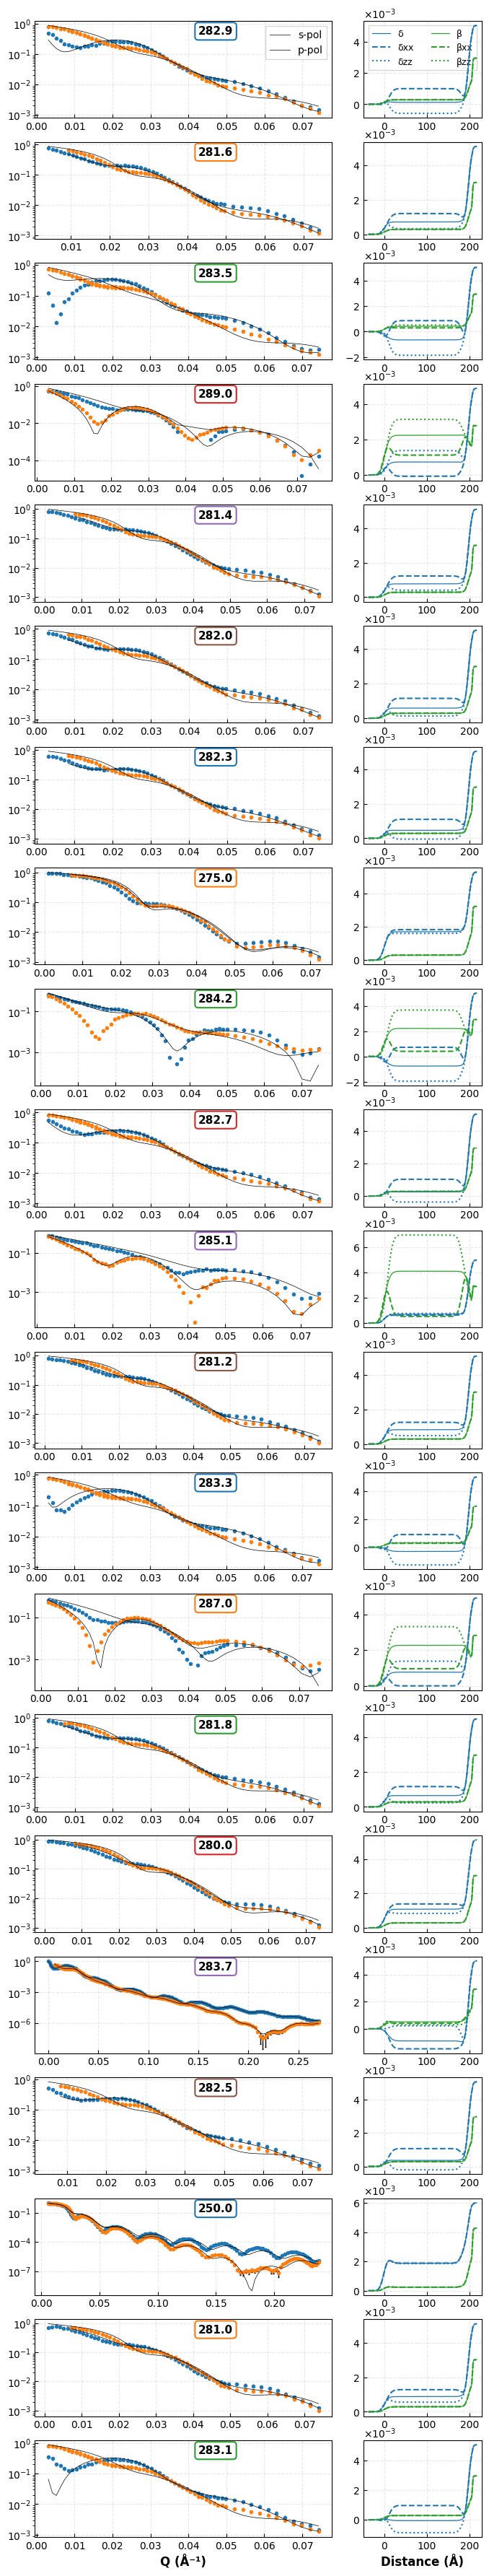

In [23]:
plot_reflectivity_and_structure(obj, figsize=(8, 2 * len(obj.objectives)))
plt.show()

In [ ]:
def fitting(
    obj: list[T],
    recursion_limit=2,
    workers=CPU,
) -> tuple[fit.GlobalObjective, fit.CurveFitter]:
    """
    Fit the model to the data using the provided objective.

    Parameters
    ----------
    obj : list[T]
        The list of objective function to minimize (can be AnisotropyObjective or
        GlobalObjective).
    recursion_limit : int, optional
        The number of times to recursively fit using differential evolution before refining with L-BFGS-B. Default is 2.
    workers : int, optional
        The number of parallel workers to use for fitting. Default is -1 (use all available).
    mcmc : bool, optional
        If True, perform MCMC sampling after fitting. Default is False.

    Returns
    -------
    tuple[fit.GlobalObjective, fit.CurveFitter]
        The fitted objective and the fitter used.
    """
    fit_objectives: list[T] = []
    for o in obj:
        fit_objectives.append(fit_dynamic(o))
    global_objective = fit.GlobalObjective(fit_objectives)  # type: ignore
    fitter = fit.CurveFitter(
        global_objective,
    )
    fitter.fit(
        target="nll",
        method="differential_evolution",
        polish=False,
        workers=workers,
        updating="deferred",
        maxiter=50,
    )
    kwargs = {"target": "nlpost", "method": "L-BFGS-B", "options": {"workers": workers}}
    for _ in range(recursion_limit - 1):
        try:
            fitter.fit(**kwargs)
            fit.fitters._fix_bounds(global_objective, by_bounds=True)
        except Exception as e:
            print(f"Error occurred during fitting: {e}")
            return global_objective, fitter

    return global_objective, fitter

In [28]:
fit_obj, fitter = fitting(objectives, recursion_limit=2, workers=CPU)

11746it [12:27, 15.71it/s, batch: 45 | bound: 28 | nc: 1 | ncall: 1470412 | eff(%):  0.796 | loglstar: -7.275 <  0.640 <  0.124 | logz: -7.348 +/-  0.086 | stop:  0.980]       
11546it [09:33, 20.14it/s, batch: 46 | bound: 14 | nc: 1 | ncall: 1311780 | eff(%):  0.877 | loglstar: -5.403 <  0.218 < -1.215 | logz: -6.003 +/-  0.078 | stop:  0.980]       
11499it [09:40, 19.82it/s, batch: 47 | bound: 16 | nc: 1 | ncall: 1311241 | eff(%):  0.874 | loglstar: -4.514 <  0.755 < -0.196 | logz: -5.828 +/-  0.078 | stop:  0.989]       
12279it [15:08, 13.51it/s, batch: 41 | bound: 23 | nc: 1 | ncall: 1654624 | eff(%):  0.742 | loglstar:   -inf < -0.800 < -2.679 | logz: -12.383 +/-  0.119 | stop:  0.986]        
12478it [10:29, 19.81it/s, batch: 40 | bound: 17 | nc: 1 | ncall: 1706394 | eff(%):  0.729 | loglstar: -7.874 < -0.555 < -2.283 | logz: -17.303 +/-  0.139 | stop:  0.996]        
11539it [10:19, 18.63it/s, batch: 47 | bound: 23 | nc: 1 | ncall: 1342619 | eff(%):  0.858 | loglstar: -6.732 <

In [29]:
import pickle

with open("fitting_results_free_model.pkl", "wb") as f:
    pickle.dump(fit_obj, f)

/tmp/ipykernel_623183/2694608493.py:367: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


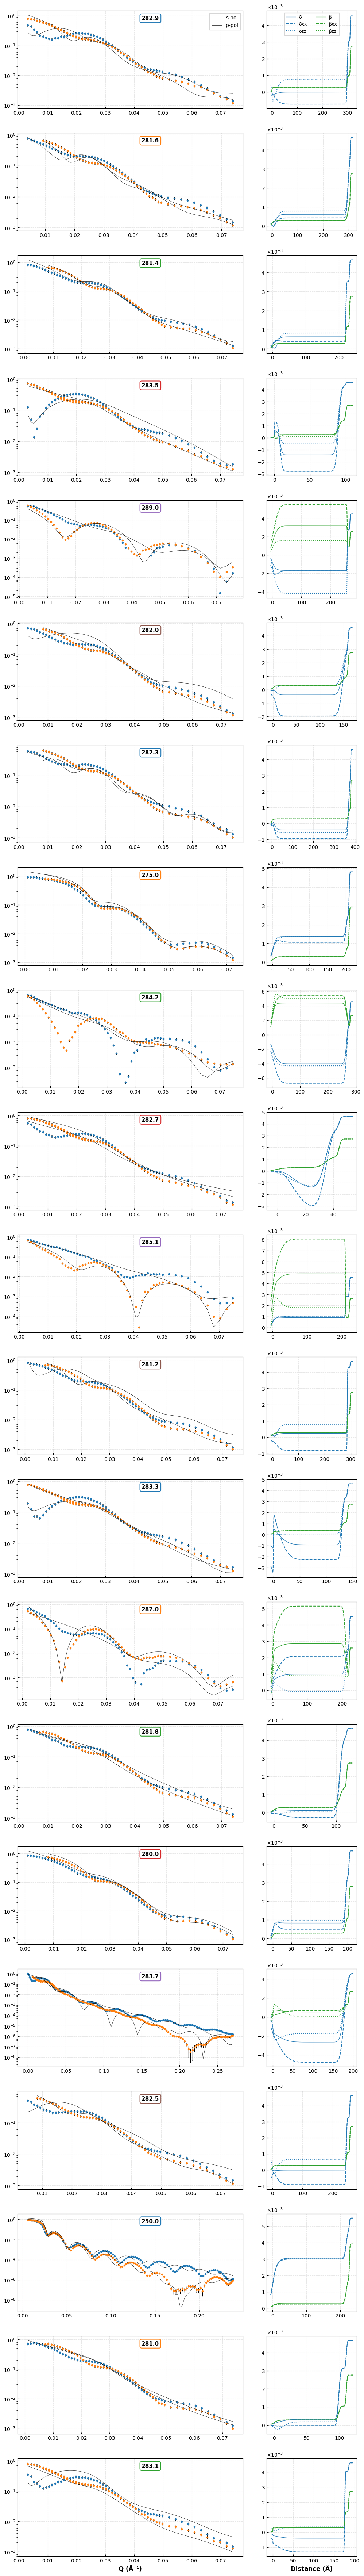

In [30]:
plot_reflectivity_and_structure(fit_obj, figsize=(12, 4 * len(fit_obj.objectives)))
plt.show()

In [47]:
print(fit_obj.varying_parameters())

________________________________________________________________________________
Parameters:      None      
<Parameter:   'scale_s'   , value=1.03665 +/- 0.013, bounds=[0.29000000000000004, 1.79]>
<Parameter:   'scale_p'   , value=1.16272 +/- 0.0138, bounds=[0.4099999999999999, 1.91]>
<Parameter:'theta_offset_s', value=0.590962 +/- 0.0163, bounds=[-0.21000000000000008, 1.3900000000000001]>
<Parameter:'theta_offset_p', value=0.36517 +/- 0.0169, bounds=[-0.43000000000000005, 1.17]>
<Parameter:'Surface_283.7_thick', value=2.31721 +/- 0.468, bounds=[0.0, 5.574999999999999]>
<Parameter:'Surface_283.7_rough', value=1.82616 +/- 2.39 , bounds=[0.0, 4.025]>
<Parameter:'Surface_283.7_density', value=0.6 +/- 0.169, bounds=[0.19999999999999996, 1.0]>
<Parameter:'Surface_283.7_rotation', value=0.955317 +/- 0.0333, bounds=[0.9553166181245093, 1.5707963267948966]>
<Parameter:'ZnPc_283.7_thick', value=190.353 +/- 0.63 , bounds=[0.0, 336.975]>
<Parameter:'ZnPc_283.7_rough', value=9.66429 +/- 0.568, bo